# Proyek Pertama : Membuat Model NLP dengan Tensorflow

- Nama: Nicolas Debrito
- Email: nicolas.debrito66@gmail.com
- ID Dicoding: reezzy

## Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from warnings import filterwarnings
filterwarnings('ignore')

## Download & Extract Dataset

Dataset diambil dari Kaggle https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d saurabhshahane/twitter-sentiment-dataset

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
twitter-sentiment-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile('twitter-sentiment-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('twitter-sentiment')

## Preprocessing Data

Dataset berjumlah 162.969 data yang bersih dan terbagi menjadi 3 sentimen (-1 untuk negatif, 0 untuk netral, 1 untuk positif)

In [5]:
df = pd.read_csv('twitter-sentiment/Twitter_Data.csv')
df = df.dropna()
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


Mengambil 10000 data untuk masing masing class

In [6]:
sample_data_df = df.groupby('category').apply(lambda x: x.sample(10000, replace=True, random_state=1)).reset_index(drop=True)
sample_data_df

,clean_text,category
0,the last years narendra modi has transformed c...,-1.0
1,you really think that was sting lolthank you w...,-1.0
2,you are ashole keep your fuking mouth shut don...,-1.0
3,sir 50years supprted gandhi family nothing don...,-1.0
4,seriously why should any tax payer will pay hi...,-1.0
...,...,...
29995,this self imposed dynasty brat not leader indi...,1.0
29996,modi takes credit for the great work done scie...,1.0
29997,right ladies who like modi may get husband lik...,1.0
29998,criticised entire opposition praises modi whic...,1.0


In [7]:
sentiment = pd.get_dummies(sample_data_df['category']).astype(int)
final_df = pd.concat([sample_data_df, sentiment], axis=1)
final_df = final_df.drop(columns='category')
final_df

,clean_text,-1.0,0.0,1.0
0,the last years narendra modi has transformed c...,1,0,0
1,you really think that was sting lolthank you w...,1,0,0
2,you are ashole keep your fuking mouth shut don...,1,0,0
3,sir 50years supprted gandhi family nothing don...,1,0,0
4,seriously why should any tax payer will pay hi...,1,0,0
...,...,...,...,...
29995,this self imposed dynasty brat not leader indi...,0,0,1
29996,modi takes credit for the great work done scie...,0,0,1
29997,right ladies who like modi may get husband lik...,0,0,1
29998,criticised entire opposition praises modi whic...,0,0,1


In [8]:
X = final_df['clean_text'].values
y = final_df[[-1, 0, 1]].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)

(24000,)
(6000,)


In [10]:
tokenizer = Tokenizer(num_words=50000, oov_token='x')

tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequence_train, padding='post', maxlen=50, truncating='post')
padded_test = pad_sequences(sequence_test, padding='post', maxlen=50, truncating='post')

## Build Model

In [19]:
model = Sequential([
    Embedding(input_dim=50000, output_dim=16),
    Conv1D(32, kernel_size=3, activation='relu'),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9):
      print("\nAkurasi telah mencapai >90%")
      self.model.stop_training = True

callbacks = myCallback()

In [22]:
history = model.fit(
    padded_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(padded_test, y_test),
    callbacks=[callbacks]
)

Epoch 1/30
750/750 [==============================] - 40s 48ms/step - loss: 0.7348 - accuracy: 0.6305 - val_loss: 0.4960 - val_accuracy: 0.8040
Epoch 2/30
750/750 [==============================] - 13s 17ms/step - loss: 0.4154 - accuracy: 0.8448 - val_loss: 0.4166 - val_accuracy: 0.8563
Epoch 3/30
750/750 [==============================] - 10s 13ms/step - loss: 0.3050 - accuracy: 0.8921 - val_loss: 0.3453 - val_accuracy: 0.8875
Epoch 4/30
750/750 [==============================] - 8s 11ms/step - loss: 0.2002 - accuracy: 0.9357 - val_loss: 0.3352 - val_accuracy: 0.8888
Epoch 5/30
750/750 [==============================] - 9s 11ms/step - loss: 0.1320 - accuracy: 0.9613 - val_loss: 0.3874 - val_accuracy: 0.8937
Epoch 6/30
750/750 [==============================] - 9s 12ms/step - loss: 0.1035 - accuracy: 0.9702 - val_loss: 0.3761 - val_accuracy: 0.8885
Epoch 7/30
750/750 [==============================] - 8s 10ms/step - loss: 0.0787 - accuracy: 0.9796 - val_loss: 0.3741 - val_accuracy: 0.8

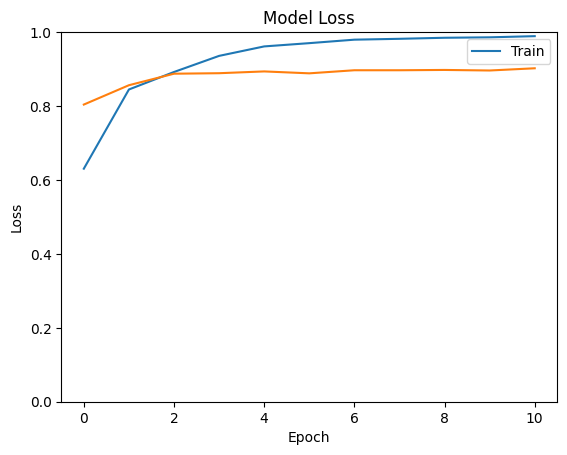

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.ylim(ymin=0, ymax=1)
plt.show()

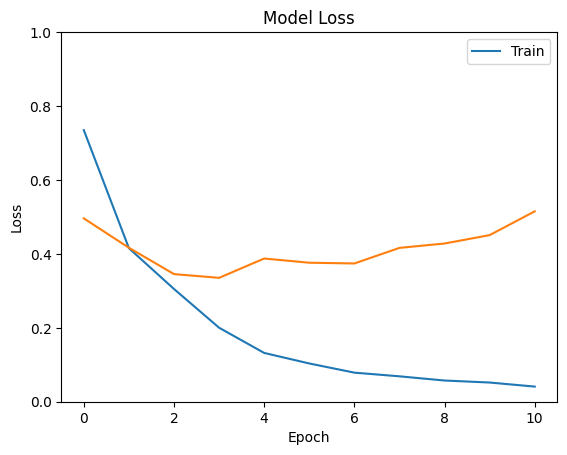

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.ylim(ymin=0, ymax=1)
plt.show()